In [27]:
# USER PARAMETERS
filesource = 'manual' # 'strava' or 'manual'
filename = 'hiking_log.csv' # in same directory as this script

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np

In [29]:
# Import spreadsheet of activity data

if filesource == 'manual':
    hikes = pd.read_csv(f'./{filename}', parse_dates=['date'])
    hikes.average_moving_pace = pd.to_timedelta(hikes.average_moving_pace)
    hikes.total_duration = pd.to_timedelta(hikes.total_duration)

elif filesource == 'strava':
    # Read Strava data and filter to necessary attributes
    activities = pd.read_csv(f'./{filename}')
    hikes = activities[activities['Activity Type'] == 'Hike']
    hikes = hikes[{'Activity Name', 'Activity Date', 'Moving Time', 'Elapsed Time', 'Distance', 'Elevation Gain', 'Elevation High'}]

    # Convert units
    hikes['date'] = pd.to_datetime(hikes['Activity Date'])
    hikes['total_duration'] = pd.to_timedelta(hikes['Elapsed Time'], unit='second')
    hikes['moving_time'] = pd.to_timedelta(hikes['Moving Time'], unit='second')
    hikes['distance_mi'] = hikes['Distance'] / 1.609 # km to mi
    hikes['average_moving_pace'] = hikes['moving_time'] / hikes['distance_mi']
    hikes['elevation_gain_ft'] = hikes['Elevation Gain'] * 3.281 # m to ft
    hikes['max_elevation_ft'] = hikes['Elevation High'] * 3.281 # m to ft

    hikes = hikes[{'date', 'total_duration', 'moving_time', 'average_moving_pace', 'distance_mi', 'elevation_gain_ft', 'max_elevation_ft'}]


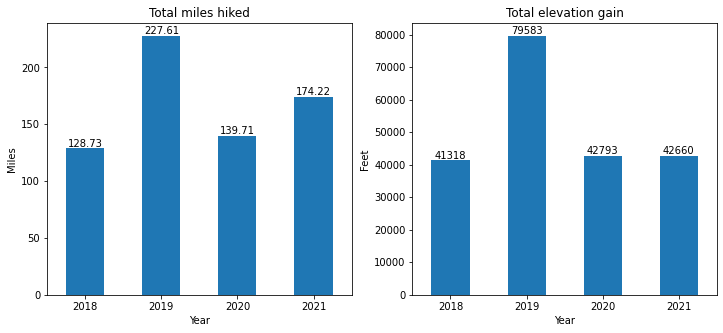

In [30]:
# Total annual miles and elevation gain
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
ax = ax.flatten()

# Total miles hiked per year
hikes.groupby(hikes.date.dt.year).sum()['distance_mi'].plot.bar(ax=ax[0], xlabel='Year', ylabel='Miles', title='Total miles hiked', rot=0)
ax[0].bar_label(ax[0].containers[0])

# Total elevation gain per year
hikes.groupby(hikes.date.dt.year).sum()['elevation_gain_ft'].plot.bar(ax=ax[1], xlabel='Year', ylabel='Feet', title='Total elevation gain', rot=0)
ax[1].bar_label(ax[1].containers[0])

plt.savefig('./total_annual_distance_elevation.png', bbox_inches='tight', dpi=300, transparent=False)
plt.show()

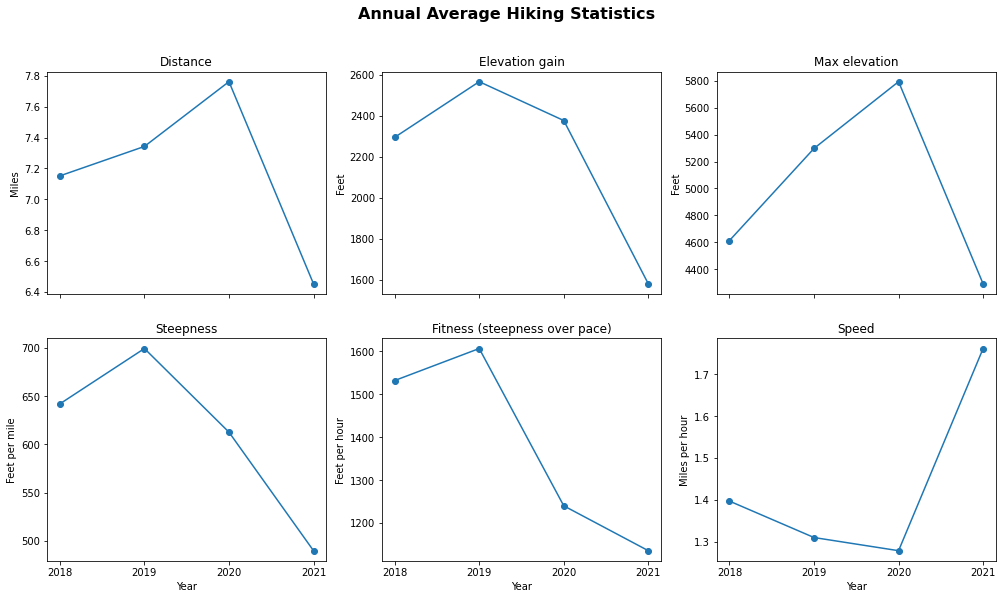

In [31]:
# Hiking stats over time
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=True, figsize=(17,9))
ax = ax.flatten()

# Calculate detailed statistics
mean_stats = hikes.groupby(hikes.date.dt.year).mean()
mean_steepness = mean_stats['elevation_gain_ft'] / (mean_stats['distance_mi'] / 2.0)
mean_pace = [(hikes[hikes.date.dt.year == y].average_moving_pace.mean().total_seconds() / 3600.0) for y in hikes.date.dt.year.unique()]
mean_fitness = mean_steepness / mean_pace
mean_duration = [(hikes[hikes.date.dt.year == y].total_duration.mean().total_seconds() / 3600.0) for y in hikes.date.dt.year.unique()]
mean_speed = mean_stats['distance_mi'] / mean_duration

# Distance
ax[0].plot(mean_stats['distance_mi'].index, mean_stats['distance_mi'].values, 'o-')
ax[0].set_title('Distance')
ax[0].set_ylabel('Miles')
ax[0].set_xticks(hikes.date.dt.year.unique())

# Elevation gain
ax[1].plot(mean_stats['elevation_gain_ft'].index, mean_stats['elevation_gain_ft'].values, 'o-')
ax[1].set_title('Elevation gain')
ax[1].set_ylabel('Feet')

# Max elevation
ax[2].plot(mean_stats['max_elevation_ft'].index, mean_stats['max_elevation_ft'].values, 'o-')
ax[2].set_title('Max elevation')
ax[2].set_ylabel('Feet')

# Mean steepness
ax[3].plot(mean_steepness.index, mean_steepness.values, 'o-')
ax[3].set_title('Steepness')
ax[3].set_xlabel('Year')
ax[3].set_ylabel('Feet per mile')

# Mean fitness
ax[4].plot(mean_fitness.index, mean_fitness.values, 'o-')
ax[4].set_title('Fitness (steepness over pace)')
ax[4].set_xlabel('Year')
ax[4].set_ylabel('Feet per hour')

# Mean speed
ax[5].plot(mean_speed.index, mean_speed.values, 'o-')
ax[5].set_title('Speed')
ax[5].set_xlabel('Year')
ax[5].set_ylabel('Miles per hour')

fig.suptitle('Annual Average Hiking Statistics', fontweight='bold', fontsize=16)
plt.savefig('./average_annual_stats.png', bbox_inches='tight', dpi=300, transparent=False)
plt.show()

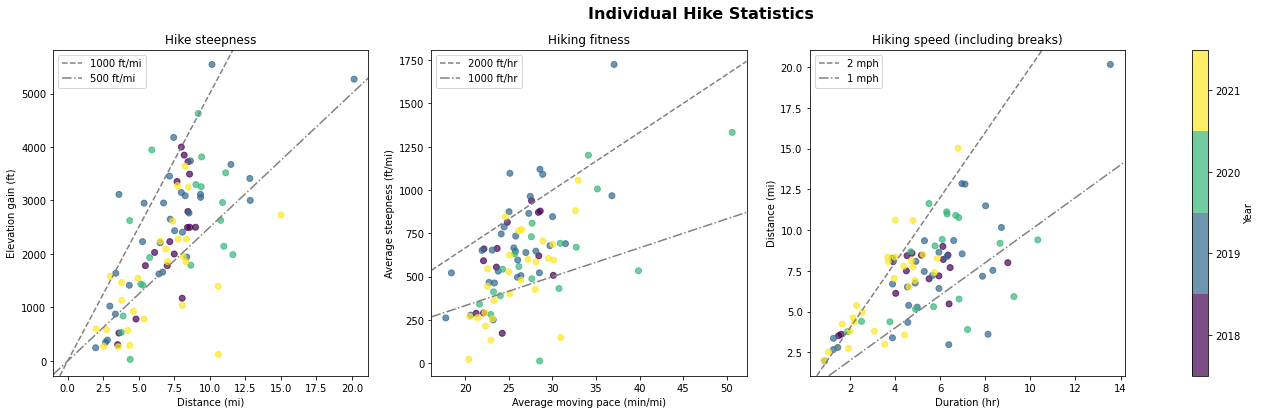

In [26]:
# Individual hiking statistics
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(24,6))
ax = ax.flatten()
cmap = plt.cm.viridis
norm = colors.BoundaryNorm(np.arange(hikes.date.dt.year.unique()[0]-0.5, hikes.date.dt.year.unique()[-1]+1.5), cmap.N)

# Annual hike steepness (elevation gain over distance)
ax[0].scatter(hikes.distance_mi, hikes.elevation_gain_ft, c=hikes.date.dt.year, cmap=cmap, norm=norm, alpha=0.7)
ax[0].axline(xy1=(0,0), slope=1000/2, linestyle='--', color='gray', label='1000 ft/mi')
ax[0].axline(xy1=(0,0), slope=500/2, linestyle='-.', color='gray', label='500 ft/mi')
ax[0].set_xlabel('Distance (mi)')
ax[0].set_ylabel('Elevation gain (ft)')
ax[0].set_title('Hike steepness')
ax[0].legend()

# Annual hike fitness (pace over steepness)
pace_minutes = [m.total_seconds()/60.0 for m in hikes.average_moving_pace]
ax[1].scatter(pace_minutes, (hikes.elevation_gain_ft / (hikes.distance_mi/2.)), c=hikes.date.dt.year, cmap=cmap, norm=norm, alpha=0.7)
ax[1].axline(xy1=(30,1000), slope=2000/60, linestyle='--', color='gray', label='2000 ft/hr')
ax[1].axline(xy1=(30,500), slope=1000/60, linestyle='-.', color='gray', label='1000 ft/hr')
ax[1].set_xlabel('Average moving pace (min/mi)')
ax[1].set_ylabel('Average steepness (ft/mi)')
ax[1].set_title('Hiking fitness')
ax[1].legend()

# Miles per hour (including breaks)
total_hours = [t.total_seconds()/3600.0 for t in hikes.total_duration]
h = ax[2].scatter(total_hours, hikes.distance_mi, c=hikes.date.dt.year, cmap=cmap, norm=norm, alpha=0.7)
ax[2].axline(xy1=(2,4), slope=2, linestyle='--', color='gray', label='2 mph')
ax[2].axline(xy1=(2,2), slope=1, linestyle='-.', color='gray', label='1 mph')
ax[2].set_xlabel('Duration (hr)')
ax[2].set_ylabel('Distance (mi)')
ax[2].set_title('Hiking speed (including breaks)')
ax[2].legend()

plt.colorbar(h, ax=ax, ticks=range(hikes.date.dt.year.unique()[0], hikes.date.dt.year.unique()[-1]+1), label='Year')

plt.suptitle('Individual Hike Statistics', fontweight='bold', fontsize=16)
plt.savefig('./individual_hike_stats.png', bbox_inches='tight', dpi=300, transparent=False)
plt.show()